In [1]:
import kabuki
import os
import hddm
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel,delayed
from glob import glob
from kabuki.analyze import gelman_rubin
import arviz
import numpy as np
from patsy import dmatrix 


from sklearn.preprocessing import StandardScaler


ModuleNotFoundError: No module named 'kabuki'

# load data(trial-level)

In [2]:
# load data
data = hddm.load_csv('./data.csv')

# stimulus onset time is 200, we should add it.
data['rt']=data['rt']+0.2
#data['response']=data['_response']

# rt of correct time should be positive, and rt of incorrect time should be negative.
df = data
df = hddm.utils.flip_errors(df)

# normalise the cpp signal
df['cpp_slope']=StandardScaler().fit_transform(df['cpp_slope'].to_numpy().reshape(-1,1))
df['cpp_amplitude']=StandardScaler().fit_transform(df['cpp_amplitude'].to_numpy().reshape(-1,1))
df['cpp_peak']=StandardScaler().fit_transform(df['cpp_peak'].to_numpy().reshape(-1,1))

# according to two experimental factors, we add a variable for four levels
df.loc[(df['coherency']=='high')&(df['prioritization']=='yes'),'level'] = 'level1'
df.loc[(df['coherency']=='high')&(df['prioritization']=='no'),'level'] = 'level2'
df.loc[(df['coherency']=='low')&(df['prioritization']=='yes'),'level'] = 'level3'
df.loc[(df['coherency']=='low')&(df['prioritization']=='no'),'level'] = 'level4'

In [4]:
df

rt  response  subj_idx attention coherency prioritization  \
0     0.433677       1.0        17    double      high             no   
1     0.551817       1.0        16     right      high            yes   
2     0.587365       1.0        15    double      high             no   
3     1.066449       1.0        14      left      high            yes   
4     0.589671       1.0        13    double      high             no   
...        ...       ...       ...       ...       ...            ...   
3656  0.501089       1.0         7      left      high            yes   
3657  1.568623       1.0         6    double       low             no   
3658  0.471034       1.0         5      left       low            yes   
3659  0.915909       1.0         3    double       low             no   
3660  0.587643       1.0         1    double      high             no   

     stimulus  run  _response   id  cpp_peak  cpp_slope  cpp_amplitude  index  \
0        face    1        0.0    0 -1.824817  -0.482734      -0.297205    0.0   
1        face    1        0.0    0 -1.667425  -0.472280      -0.092012    0.0   
2        face    1        0.0    0 -0.863027   0.180385       0.126610    0.0   
3         car    1        1.0    0 -0.526663  -2.079853      -2.005747    0.0   
4        face    1        0.0    0 -0.144199  -1.303417       0.850449    0.0   
...       ...  ...        ...  ...       ...        ...            ...    ...   
3656      car    2        1.0  143 -0.206000  -0.584398      -0.222300  287.0   
3657     face    2        0.0  143 -1.819133  -0.576648      -1.742709  287.0   
3658      car    2        1.0  143  0.608804  -1.450427      -0.559594  287.0   
3659      car    2        1.0  143 -0.292660  -0.869685      -0.712878  287.0   
3660     face    2        0.0  143 -0.110973   0.170022       0.088284  287.0   

       level  
0     level2  
1     level1  
2     level2  
3     level1  
4     level2  
...      ...  
3656  level1  
3657  level4  
3658  level3  
3659  level4  
3660  level2  

[3661 rows x 15 columns]

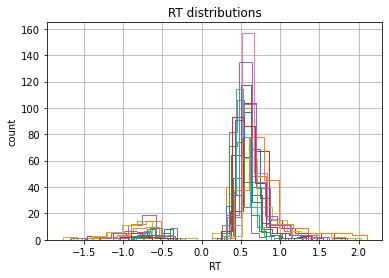

In [5]:
# link function for stimulus, one stimulus should be coded 0, another should be coded 1
def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                                  {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
        )
        # Apply z = (1 - x) to flip them along 0.5
        z_flip = np.subtract(stim, x.to_frame())
        # The above inverts those values we do not want to flip,
        # so invert them back
        z_flip[stim == 0] *= -1
        return z_flip


In [ ]:
# plot for checking the rt distribution of two response
fig = plt.figure()

ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')

for i, subj_data in df.groupby('subj_idx'):

    subj_data.rt.hist(bins=20, histtype='step', ax=ax)


# behavior model: v ~ level

In [13]:
def run_m3(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    m = hddm.HDDMRegressor(df,"v ~ C(coherency, Treatment('low'))" ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m3 = Parallel(n_jobs = 8)(delayed(run_m3)(id = i, df = df, samples=4000,burn = 2000,thin=2, save_name = '2_4_2_2_temp/m3' ) for i in range(8))

Adding these covariates:
['v_Intercept', "v_C(coherency, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', "v_C(coherency, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', "v_C(coherency, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', "v_C(coherency, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', "v_C(coherency, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', "v_C(coherency, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', "v_C(coherency, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', "v_C(coherency, Treatment('low'))[T.high]"]


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

[                  0%                  ] 3 of 4000 complete in 0.6 sec
[                  0%                  ] 3 of 4000 complete in 0.5 sec
[                  0%                  ] 3 of 4000 complete in 0.6 sec
[                  0%                  ] 3 of 4000 complete in 0.6 sec
[                  0%                  ] 3 of 4000 complete in 0.5 sec
[                  0%                  ] 3 of 4000 complete in 0.6 sec
[                  0%                  ] 6 of 4000 complete in 1.2 sec
[                  0%                  ] 6 of 4000 complete in 1.2 sec
[                  0%                  ] 6 of 4000 complete in 1.3 sec
[                  0%                  ] 6 of 4000 complete in 1.3 sec
[                  0%                  ] 6 of 4000 complete in 1.2 sec
[                  0%                  ] 6 of 4000 complete in 1.3 sec
[                  0%                  ] 3 of 4000 complete in 0.6 sec
[                  0%                  ] 9 of 4000 complete in 1.8 sec
[     

# behavior model: v ~ level, z ~ level 

In [8]:
def run_m4(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    
    v_reg={'model': "v~1+C(level)", 'link_func': lambda x:x}
    
    z_reg={'model': "z~1+C(level)", 'link_func': z_link_func}

    m = hddm.HDDMRegressor(df, [v_reg, z_reg] ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m4 = Parallel(n_jobs = 4)(delayed(run_m4)(id = i, df = df, samples=2000,burn = 1000,thin=1, save_name = '2_4_2_3_temp/m4' ) for i in range(4))

Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]']
Adding these covariates:
['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]']
Adding these covariates:
['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']
Adding these covariates:
['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]']
Adding these covariates:
['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

[                  0%                  ] 2 of 2000 complete in 1.3 sec
[                  0%                  ] 2 of 2000 complete in 1.3 sec
[                  0%                  ] 2 of 2000 complete in 1.4 sec
[                  0%                  ] 2 of 2000 complete in 1.4 sec
[                  0%                  ] 3 of 2000 complete in 2.7 sec
[                  0%                  ] 3 of 2000 complete in 2.7 sec
[                  0%                  ] 3 of 2000 complete in 2.9 sec
[                  0%                  ] 3 of 2000 complete in 2.9 sec
[                  0%                  ] 4 of 2000 complete in 4.1 sec
[                  0%                  ] 4 of 2000 complete in 4.1 sec
[                  0%                  ] 4 of 2000 complete in 4.4 sec
[                  0%                  ] 4 of 2000 complete in 4.4 sec
[                  0%                  ] 5 of 2000 complete in 5.6 sec
[                  0%                  ] 5 of 2000 complete in 5.5 sec
[     

# behavior model: v ~ level, t ~ level

In [18]:

def run_m5(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    
    v_reg={'model': "v~1+C(level)", 'link_func': lambda x:x}
    
    t_reg={'model': "t~1+C(level)", 'link_func': lambda x:x}

    m = hddm.HDDMRegressor(df, [v_reg, t_reg] ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m5 = Parallel(n_jobs = 4)(delayed(run_m5)(id = i, df = df, samples=4000,burn = 2000,thin=2, save_name = '2_4_2_3_temp/m5' ) for i in range(4))



Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]']
Adding these covariates:
['t_Intercept', 't_C(level)[T.level2]', 't_C(level)[T.level3]', 't_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]']
Adding these covariates:
['t_Intercept', 't_C(level)[T.level2]', 't_C(level)[T.level3]', 't_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]']
Adding these covariates:
['t_Intercept', 't_C(level)[T.level2]', 't_C(level)[T.level3]', 't_C(level)[T.level4]']
Adding these covariates:
['t_Intercept', 't_C(level)[T.level2]', 't_C(level)[T.level3]', 't_C(level)[T.level4]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


[                  0%                  ] 2 of 4000 complete in 0.5 sec
[                  0%                  ] 3 of 4000 complete in 1.0 sec
[                  0%                  ] 3 of 4000 complete in 0.9 sec
[                  0%                  ] 3 of 4000 complete in 1.0 sec
[                  0%                  ] 3 of 4000 complete in 1.0 sec
[                  0%                  ] 4 of 4000 complete in 1.5 sec
[                  0%                  ] 4 of 4000 complete in 1.6 sec
[                  0%                  ] 4 of 4000 complete in 1.5 sec
[                  0%                  ] 5 of 4000 complete in 1.9 sec
[                  0%                  ] 5 of 4000 complete in 2.0 sec
[                  0%                  ] 5 of 4000 complete in 2.0 sec
[                  0%                  ] 5 of 4000 complete in 2.2 sec
[                  0%                  ] 6 of 4000 complete in 2.4 sec
[                  0%                  ] 6 of 4000 complete in 2.6 sec
[     

# trial-level model: v ~ level, cpp_slope, z ~ level

In [19]:
def run_m6_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_slope+cpp_slope:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m6_z = Parallel(n_jobs = 4)(delayed(run_m6_z)(id = i, df = df, samples=2000,burn = 1000,thin=1, save_name = '2_4_2_3_temp/m6_z' ) for i in range(4))

Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_slope', 'v_cpp_slope:C(level)[T.level2]', 'v_cpp_slope:C(level)[T.level3]', 'v_cpp_slope:C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_slope', 'v_cpp_slope:C(level)[T.level2]', 'v_cpp_slope:C(level)[T.level3]', 'v_cpp_slope:C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_slope', 'v_cpp_slope:C(level)[T.level2]', 'v_cpp_slope:C(level)[T.level3]', 'v_cpp_slope:C(level)[T.level4]']
Adding these covariates:
['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_slope', 'v_cpp_slope:C(level)[T.level2]', 'v_cpp_slope:C(level)[T.level3]', '

/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

[                  0%                  ] 2 of 2000 complete in 1.7 sec
[                  0%                  ] 2 of 2000 complete in 1.8 sec
[                  0%                  ] 3 of 2000 complete in 3.6 sec
[                  0%                  ] 2 of 2000 complete in 1.9 sec
[                  0%                  ] 2 of 2000 complete in 1.9 sec
[                  0%                  ] 3 of 2000 complete in 3.5 sec
[                  0%                  ] 3 of 2000 complete in 3.6 sec
[                  0%                  ] 4 of 2000 complete in 5.4 sec
[                  0%                  ] 3 of 2000 complete in 3.8 sec
[                  0%                  ] 4 of 2000 complete in 5.2 sec
[                  0%                  ] 5 of 2000 complete in 7.0 sec
[                  0%                  ] 4 of 2000 complete in 5.5 sec
[                  0%                  ] 4 of 2000 complete in 5.5 sec
[                  0%                  ] 5 of 2000 complete in 6.9 sec
[     

# trial-level model: v ~ level, cpp_amplitude, z ~ level

In [20]:
def run_m7_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_amplitude+cpp_amplitude:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m7_z = Parallel(n_jobs = 4)(delayed(run_m7_z)(id = i, df = df, samples=4000,burn = 2000,thin=1, save_name = '2_4_2_3_temp/m7_z' ) for i in range(4))

Adding these covariates:Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_amplitude', 'v_cpp_amplitude:C(level)[T.level2]', 'v_cpp_amplitude:C(level)[T.level3]', 'v_cpp_amplitude:C(level)[T.level4]']

['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_amplitude', 'v_cpp_amplitude:C(level)[T.level2]', 'v_cpp_amplitude:C(level)[T.level3]', 'v_cpp_amplitude:C(level)[T.level4]']
Adding these covariates:Adding these covariates:
['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']

['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_amplitude', 'v_cpp_amplitude:C(level)[T.level2]', 'v_cpp_amplitude:C(level)[T.level3]', 'v_cpp_amplitude:C(level)[T.level4]']
Adding these covariates:
['z_Interce

/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

[                  0%                  ] 2 of 4000 complete in 1.9 sec
[                  0%                  ] 2 of 4000 complete in 1.9 sec
[                  0%                  ] 2 of 4000 complete in 1.9 sec
[                  0%                  ] 3 of 4000 complete in 3.8 sec
[                  0%                  ] 3 of 4000 complete in 3.9 sec
[                  0%                  ] 2 of 4000 complete in 1.9 sec
[                  0%                  ] 3 of 4000 complete in 3.9 sec
[                  0%                  ] 4 of 4000 complete in 5.6 sec
[                  0%                  ] 4 of 4000 complete in 5.7 sec
[                  0%                  ] 3 of 4000 complete in 3.8 sec
[                  0%                  ] 4 of 4000 complete in 5.9 sec
[                  0%                  ] 5 of 4000 complete in 7.1 sec
[                  0%                  ] 4 of 4000 complete in 5.4 sec
[                  0%                  ] 5 of 4000 complete in 7.5 sec
[     

# trial-level model: v ~ level, cpp_peak, z ~ level

In [21]:
def run_m8_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_peak+cpp_peak:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m8_z = Parallel(n_jobs = 4)(delayed(run_m8_z)(id = i, df = df, samples=4000,burn = 2000,thin=1, save_name = '2_4_2_3_temp/m8_z' ) for i in range(4))

Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_peak', 'v_cpp_peak:C(level)[T.level2]', 'v_cpp_peak:C(level)[T.level3]', 'v_cpp_peak:C(level)[T.level4]']
Adding these covariates:
['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_peak', 'v_cpp_peak:C(level)[T.level2]', 'v_cpp_peak:C(level)[T.level3]', 'v_cpp_peak:C(level)[T.level4]']
Adding these covariates:
['z_Intercept', 'z_C(level)[T.level2]', 'z_C(level)[T.level3]', 'z_C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(level)[T.level4]', 'v_cpp_peak', 'v_cpp_peak:C(level)[T.level2]', 'v_cpp_peak:C(level)[T.level3]', 'v_cpp_peak:C(level)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(level)[T.level2]', 'v_C(level)[T.level3]', 'v_C(le

/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

[                  0%                  ] 2 of 4000 complete in 1.7 sec
[                  0%                  ] 2 of 4000 complete in 1.7 sec
[                  0%                  ] 2 of 4000 complete in 1.7 sec
[                  0%                  ] 3 of 4000 complete in 3.2 sec
[                  0%                  ] 3 of 4000 complete in 3.2 sec
[                  0%                  ] 3 of 4000 complete in 3.3 sec
[                  0%                  ] 2 of 4000 complete in 1.7 sec
[                  0%                  ] 4 of 4000 complete in 4.9 sec
[                  0%                  ] 4 of 4000 complete in 4.8 sec
[                  0%                  ] 4 of 4000 complete in 4.9 sec
[                  0%                  ] 3 of 4000 complete in 3.3 sec
[                  0%                  ] 5 of 4000 complete in 6.4 sec
[                  0%                  ] 5 of 4000 complete in 6.2 sec
[                  0%                  ] 5 of 4000 complete in 6.5 sec
[     

# load data(subject-level)

In [22]:
# load data
data = hddm.load_csv('./data.csv')

# stimulus onset time is 200ms, we should add it.
data['rt']=data['rt']+0.2
#data['response']=data['_response']

# rt of correct time should be positive, and rt of incorrect time should be negative.
df = data
df = hddm.utils.flip_errors(df)

# average the cpp signal for every subject
for subj in df.subj_idx.unique():
    df.loc[df['subj_idx']==subj,'cpp_slope']=df.loc[df['subj_idx']==subj,'cpp_slope'].mean()

    df.loc[df['subj_idx']==subj,'cpp_amplitude']=df.loc[df['subj_idx']==subj,'cpp_amplitude'].mean()

    df.loc[df['subj_idx']==subj,'cpp_peak']=df.loc[df['subj_idx']==subj,'cpp_peak'].mean()

# normalise the cpp signal
df['cpp_slope']=StandardScaler().fit_transform(df['cpp_slope'].to_numpy().reshape(-1,1))
df['cpp_amplitude']=StandardScaler().fit_transform(df['cpp_amplitude'].to_numpy().reshape(-1,1))
df['cpp_peak']=StandardScaler().fit_transform(df['cpp_peak'].to_numpy().reshape(-1,1))

# subject-level model: v ~ level, cpp_slope, z ~ level

In [24]:
def run_m8_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_slope+cpp_slope:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m8_z = Parallel(n_jobs = 4)(delayed(run_m8_z)(id = i, df = df, samples=4000,burn = 2000,thin=1, save_name = '2_4_2_3_temp/m6_nov_sub' ) for i in range(4))

Process LokyProcess-27:
Process LokyProcess-26:
Traceback (most recent call last):
  File "/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/patsy/compat.py", line 36, in call_and_wrap_exc
    return f(*args, **kwargs)
  File "/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/patsy/eval.py", line 165, in eval
    return eval(code, {}, VarLookupDict([inner_namespace]
  File "<string>", line 1, in <module>
NameError: name 'level' is not defined

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/patsy/compat.py", line 36, in call_and_wrap_exc
    return f(*args, **kwargs)
  File "/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/patsy/eval.py", line 165, in eval
    return eval(code, {}, VarLookupDict([inner_namespace]
  File "<string>", line 1, in <module>
  File "/home/yikan

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1), EXIT(1), EXIT(1), EXIT(1)}

# subject-level model: v ~ level, cpp_amplitude, z ~ level

In [ ]:
def run_m8_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_amplitude+cpp_amplitude:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m8_z = Parallel(n_jobs = 4)(delayed(run_m8_z)(id = i, df = df, samples=4000,burn = 2000,thin=1, save_name = '2_4_2_3_temp/m7_nov_sub' ) for i in range(4))

# subject-level model: v ~ level, cpp_peak, z ~ level

In [ ]:
def run_m8_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_peak+cpp_peak:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m8_z = Parallel(n_jobs = 4)(delayed(run_m8_z)(id = i, df = df, samples=4000,burn = 2000,thin=1, save_name = '2_4_2_3_temp/m8_nov_sub' ) for i in range(4))

# subject-level model: v ~ level, cpp_slope, z ~ level with sv, sz, st

In [ ]:
def run_m8_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_slope+cpp_slope:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z','sv','st','sz'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m8_z = Parallel(n_jobs = 4)(delayed(run_m8_z)(id = i, df = df, samples=4000,burn = 2000,thin=1, save_name = '2_4_2_3_temp/m6_v_sub' ) for i in range(4))

# subject-level model: v ~ level, cpp_amplitude, z ~ level with sv, sz, st

In [ ]:
def run_m8_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_amplitude+cpp_amplitude:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z','sv','st','sz'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m8_z = Parallel(n_jobs = 4)(delayed(run_m8_z)(id = i, df = df, samples=4000,burn = 2000,thin=1, save_name = '2_4_2_3_temp/m7_v_sub' ) for i in range(4))

# subject-level model: v ~ level, cpp_peak, z ~ level with sv, sz, st

In [ ]:
def run_m8_z(id, df=None, samples=None, burn=None,thin=1, save_name=None): 
    
    dbname = save_name + '_chain_%i.db'%id 

    mname  = save_name + '_chain_%i'%id    
   
    v_reg={'model': "v~1+C(level)+cpp_peak+cpp_peak:C(level)", 'link_func': lambda x: x}
    
    z_reg={'model': "z~1+C(level)", 'link_func':  z_link_func}
    
    m=hddm.HDDMRegressor(df ,[v_reg, z_reg] ,include=['z','sv','st','sz'],keep_regressor_trace=True, group_only_regressors = False)  
    
    m.find_starting_values()
    
    m.sample(samples, burn=burn, dbname=dbname, thin=thin,db='pickle') 
    
    m.save(mname)
    
    return m

m8_z = Parallel(n_jobs = 4)(delayed(run_m8_z)(id = i, df = df, samples=4000,burn = 2000,thin=1, save_name = '2_4_2_3_temp/m8_v_sub' ) for i in range(4))